# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple_bern, get_model_hierarchical_bern
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.model import get_model_pyBasket_independent, get_model_pyBasket_independent_nc
from pyBasket.synthetic_data import generate_pyBasket_data

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
results = generate_pyBasket_data()    
data_df = results['data_df']
true_basket_p = results['true_basket_p']
true_cluster_p = results['true_cluster_p']
true_interaction_p = results['true_interaction_p']
true_joint_p = results['true_joint_p']
n_tissues = results['n_tissues']
n_clusters = results['n_clusters']

In [7]:
data_df

,basket_number,cluster_number,responsive
0,6,6,1
1,19,3,1
2,14,0,0
3,10,4,1
4,7,6,1
...,...,...,...
495,4,8,0
496,11,4,1
497,15,2,1
498,15,4,1


In [8]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})
true_cluster_df = pd.DataFrame({'prob': true_cluster_p, 'cluster': range(len(true_cluster_p))})

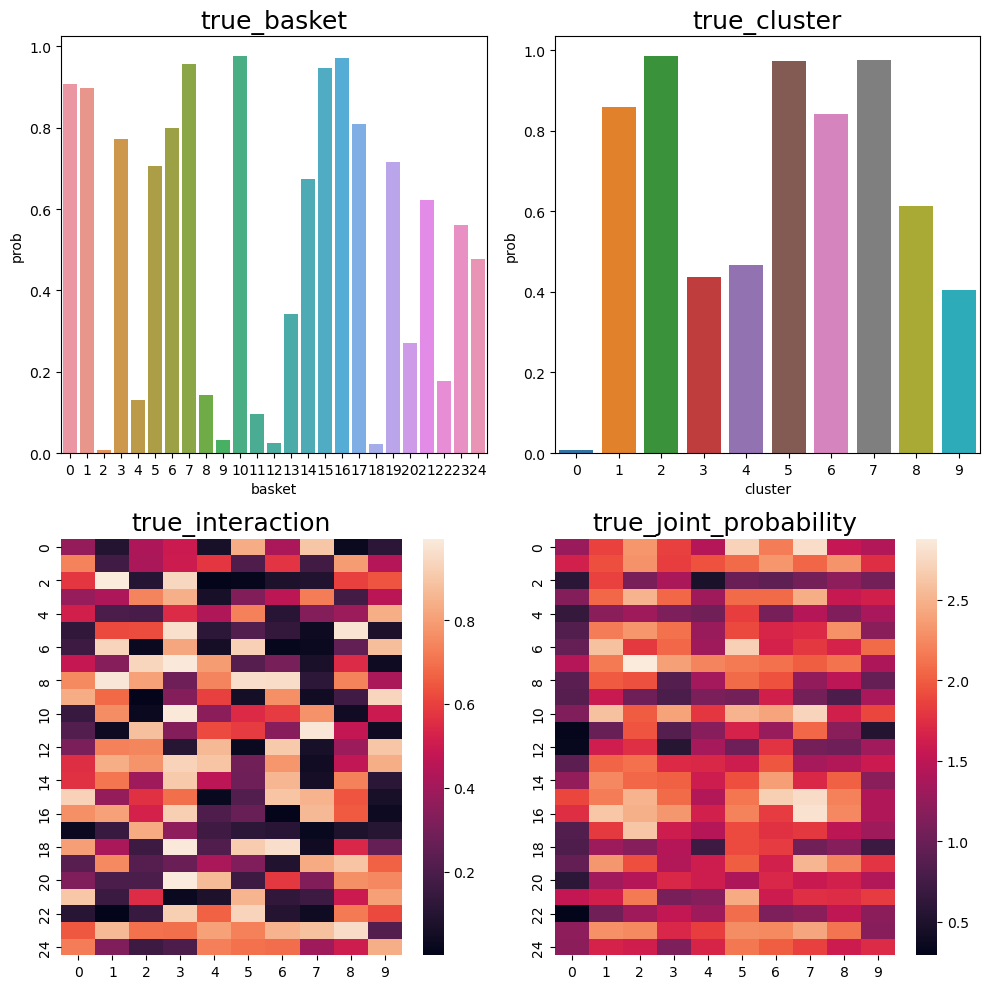

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0][0])
sns.barplot(data=true_cluster_df, x='cluster', y='prob', ax=ax[0][1])
sns.heatmap(true_interaction_p, ax=ax[1][0])
sns.heatmap(true_joint_p, ax=ax[1][1])

ax[0][0].set_title('true_basket', fontsize=18)
ax[0][1].set_title('true_cluster', fontsize=18)
ax[1][0].set_title('true_interaction', fontsize=18)
ax[1][1].set_title('true_joint_probability', fontsize=18)
plt.tight_layout()

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

The likelihood of a patient observation depends on the probability of their basket * cluster interaction, following a Bernoulli distribution with Beta priors.

Assumes that basket and cluster interaction probabilities are independent.

In [11]:
model_s = get_model_simple_bern(data_df, n_tissues, n_clusters)

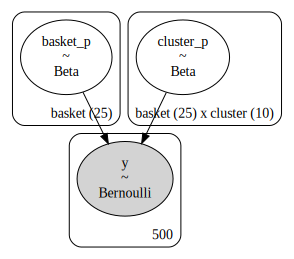

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 243 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[0],0.90,0.09,0.73,1.00,0.0,0.0,21744.0,11622.0,1.0
basket_p[1],0.91,0.08,0.77,1.00,0.0,0.0,26216.0,11501.0,1.0
basket_p[2],0.25,0.15,0.03,0.53,0.0,0.0,29675.0,14975.0,1.0
basket_p[3],0.92,0.07,0.78,1.00,0.0,0.0,24224.0,11371.0,1.0
basket_p[4],0.83,0.13,0.59,1.00,0.0,0.0,24532.0,12344.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 5]",0.75,0.19,0.39,1.00,0.0,0.0,40659.0,11616.0,1.0
"cluster_p[24, 6]",0.67,0.24,0.25,1.00,0.0,0.0,42288.0,11538.0,1.0
"cluster_p[24, 7]",0.67,0.24,0.24,1.00,0.0,0.0,38287.0,11358.0,1.0
"cluster_p[24, 8]",0.63,0.19,0.30,0.98,0.0,0.0,28668.0,9886.0,1.0


In [15]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

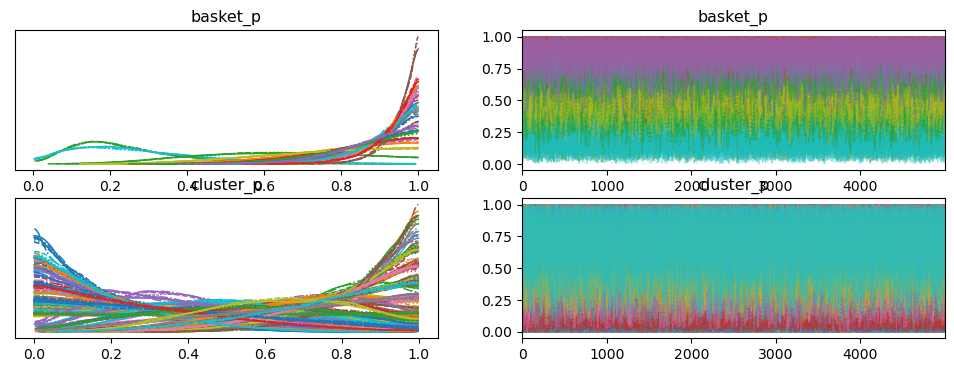

In [16]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

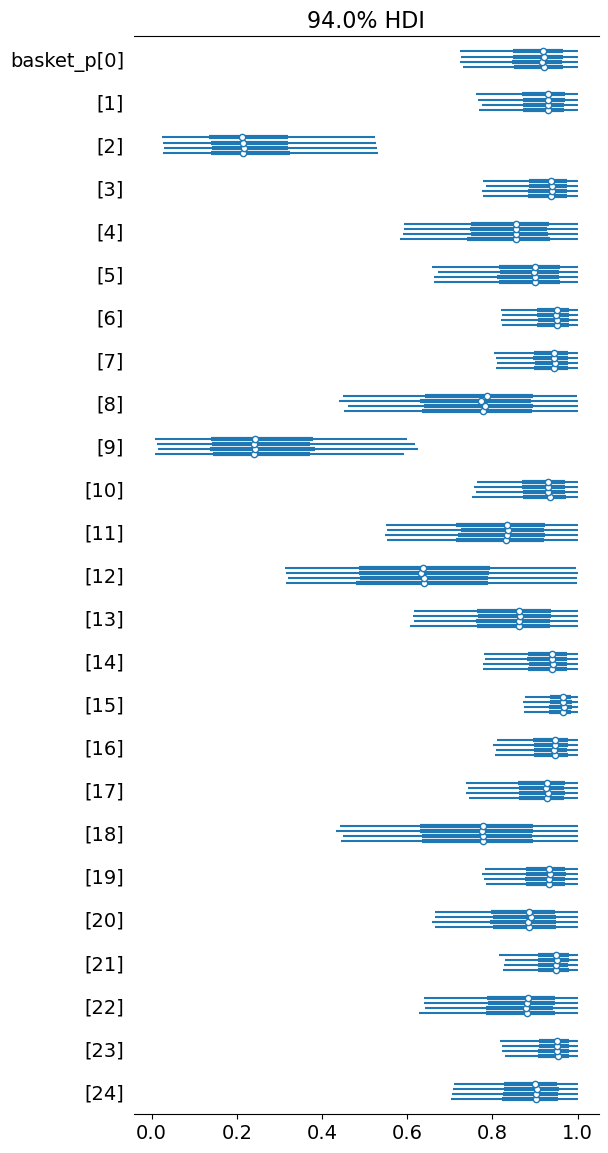

In [17]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [18]:
stacked_s = az.extract(trace_s)

In [19]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.40074660952043795)

In [20]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)
true_interaction_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_interaction_p, inferred_cluster_p))

((25, 10), (25, 10), 0.3255292303230168)

In [21]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_s = inferred_basket_p_tiled * inferred_cluster_p
true_joint_p.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

### pyBasket model (initial)

Same as above but add priors.

In [22]:
model_h1 = get_model_pyBasket_independent(data_df, n_tissues, n_clusters)

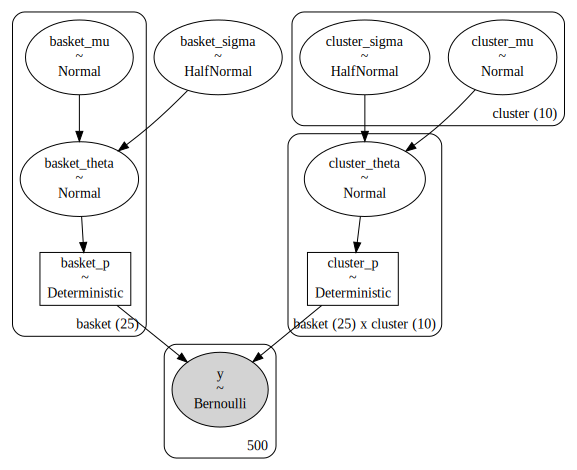

In [23]:
pm.model_to_graphviz(model_h1)

In [24]:
# with model_h1:
#     trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

This is the one we actually use after reparameterisation.

In [25]:
model_h1_nc = get_model_pyBasket_independent_nc(data_df, n_tissues, n_clusters)

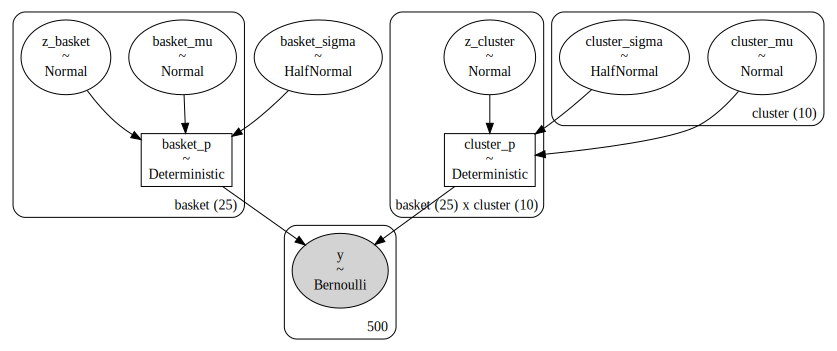

In [26]:
pm.model_to_graphviz(model_h1_nc)

In [27]:
with model_h1_nc:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 455 seconds.


In [28]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],0.62,0.86,-1.06,2.20,0.01,0.01,12201.0,13566.0,1.0
z_basket[1],0.65,0.85,-0.97,2.24,0.01,0.01,11925.0,11934.0,1.0
z_basket[2],-0.45,0.80,-1.91,1.14,0.01,0.01,10327.0,10927.0,1.0
z_basket[3],0.84,0.87,-0.85,2.46,0.01,0.01,11016.0,11146.0,1.0
z_basket[4],0.23,0.81,-1.32,1.77,0.01,0.01,12763.0,13229.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 5]",0.97,0.04,0.92,1.00,0.00,0.00,19198.0,14600.0,1.0
"cluster_p[24, 6]",0.77,0.18,0.44,1.00,0.00,0.00,19525.0,15288.0,1.0
"cluster_p[24, 7]",0.94,0.07,0.83,1.00,0.00,0.00,18720.0,13856.0,1.0
"cluster_p[24, 8]",0.84,0.13,0.61,1.00,0.00,0.00,14473.0,12736.0,1.0


In [29]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

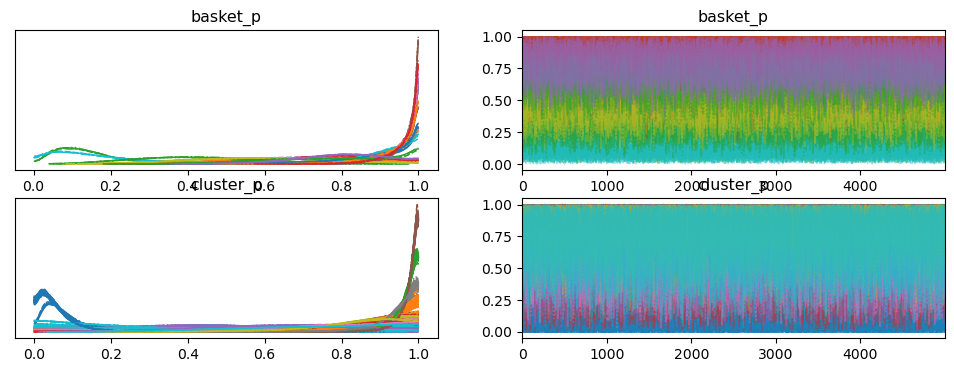

In [30]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

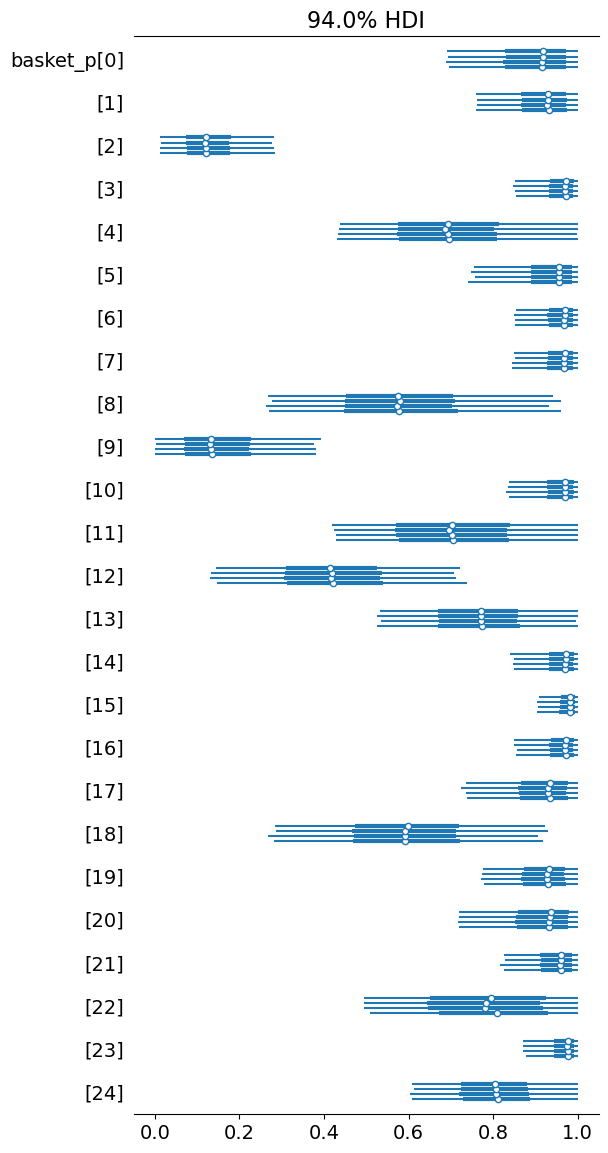

In [31]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [32]:
stacked_h1 = az.extract(trace_h1)

In [33]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.3415718207774764)

In [34]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)
true_interaction_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_interaction_p, inferred_cluster_p))

((25, 10), (25, 10), 0.47501444962995476)

In [35]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p
true_joint_p.shape, inferred_basket_p_tiled.shape, inferred_mat_h1.shape

((25, 10), (25, 10), (25, 10))

### pyBasket model (logistic regression)

Should be the final version used in the paper.

In [36]:
model_pyBasket = get_model_pyBasket(data_df, n_tissues, n_clusters)

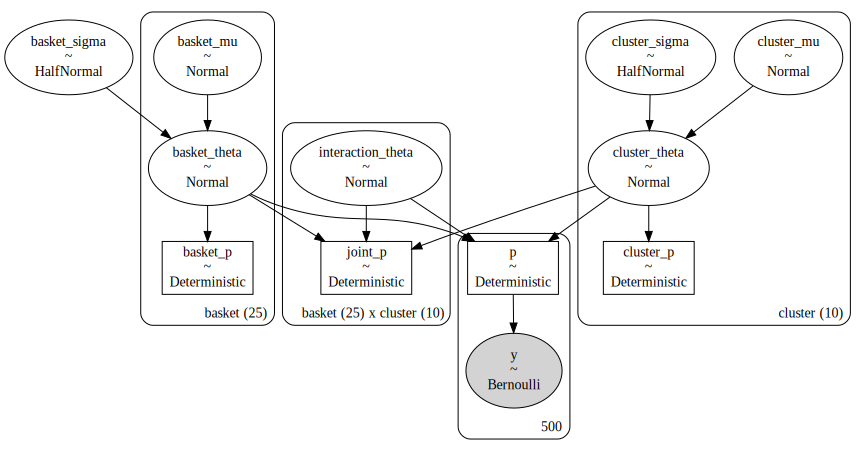

In [37]:
pm.model_to_graphviz(model_pyBasket)

In [38]:
# with model_pyBasket:
#     trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [39]:
model_pyBasket_nc = get_model_pyBasket_nc(data_df, n_tissues, n_clusters)

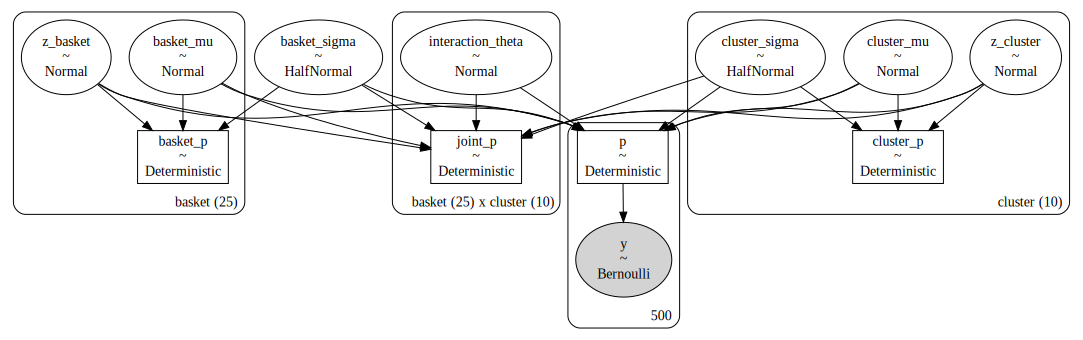

In [40]:
pm.model_to_graphviz(model_pyBasket_nc)

In [41]:
with model_pyBasket_nc:
    trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma, interaction_theta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 815 seconds.


In [42]:
az.summary(trace_pyBasket).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],0.05,0.94,-1.67,1.87,0.00,0.01,42328.0,15113.0,1.0
z_basket[1],0.15,0.95,-1.65,1.93,0.00,0.01,38979.0,14585.0,1.0
z_basket[2],-0.51,0.99,-2.44,1.27,0.01,0.01,23506.0,15983.0,1.0
z_basket[3],0.30,0.96,-1.51,2.13,0.00,0.01,37551.0,15465.0,1.0
z_basket[4],-0.23,0.96,-2.07,1.55,0.00,0.01,34165.0,14997.0,1.0
...,...,...,...,...,...,...,...,...,...
p[495],0.17,0.18,0.00,0.52,0.00,0.00,33517.0,15454.0,1.0
p[496],0.16,0.12,0.00,0.38,0.00,0.00,27111.0,17857.0,1.0
p[497],0.98,0.03,0.94,1.00,0.00,0.00,35272.0,16092.0,1.0
p[498],0.77,0.17,0.46,1.00,0.00,0.00,24093.0,17062.0,1.0


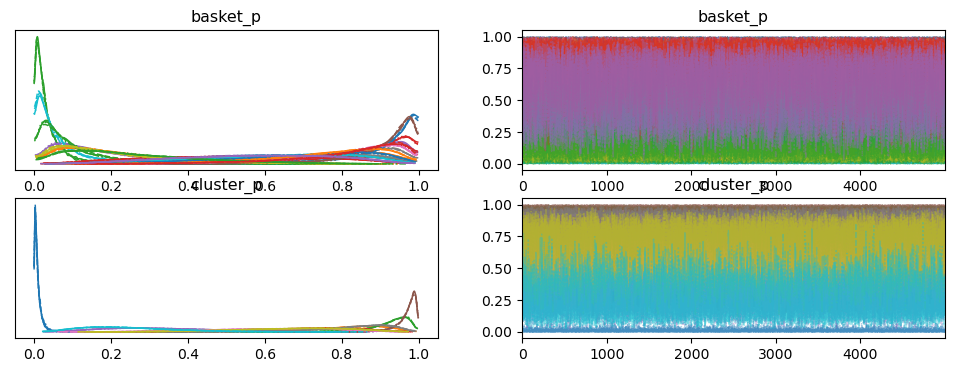

In [43]:
az.plot_trace(trace_pyBasket, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

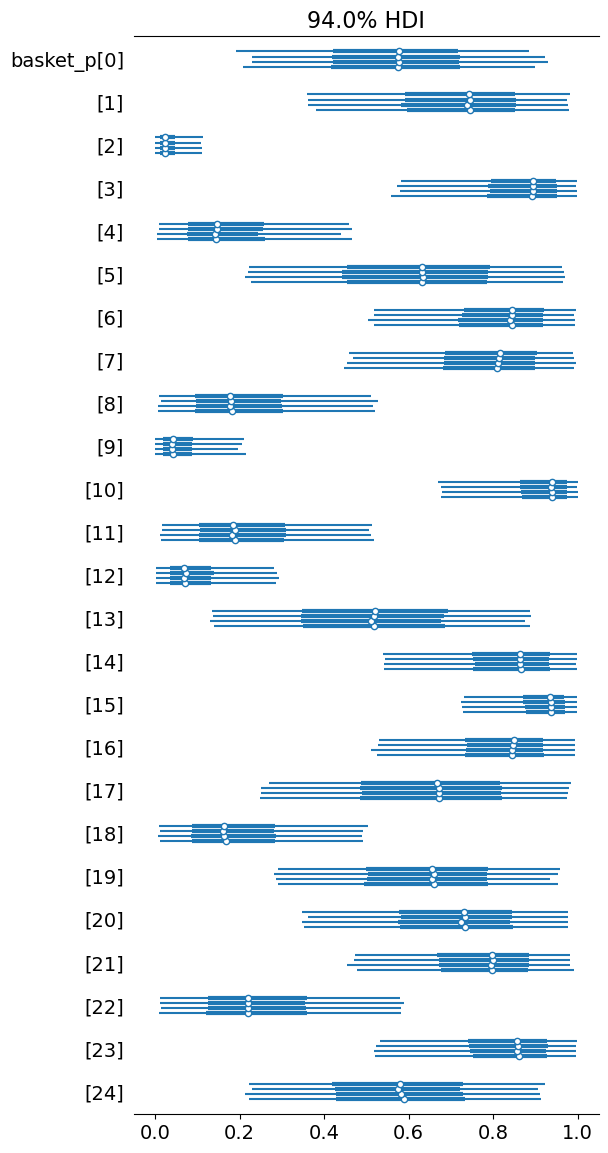

In [44]:
az.plot_forest(trace_pyBasket, var_names=['basket_p'])

In [45]:
stacked_pyBasket = az.extract(trace_pyBasket)

In [46]:
inferred_basket_p = np.mean(stacked_pyBasket.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.16407737031684805)

In [47]:
inferred_cluster_p = np.mean(stacked_pyBasket.cluster_p.values, axis=1)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((10,), (10,), 0.1373027309651341)

In [48]:
inferred_joint_p = np.mean(stacked_pyBasket.joint_p.values, axis=2)
true_joint_p.shape, inferred_joint_p.shape, math.sqrt(mean_squared_error(true_joint_p, inferred_joint_p))

((25, 10), (25, 10), 1.1141373229357414)

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [49]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_pyBasket.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,simple,0.400747
1,hierarchical,0.341572
2,pyBasket,0.164077


Calculate root mean squared error for the joint probabilities

In [50]:
actual = true_joint_p

predicted_cluster_s = inferred_mat_s
rmse_s = math.sqrt(mean_squared_error(actual, predicted_cluster_s))

predicted_cluster_h1 = inferred_mat_h1
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_cluster_h1))

predicted_cluster_h2 = inferred_joint_p
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,simple,1.251693
1,hierarchical,1.146606
2,pyBasket,1.114137


Make plot

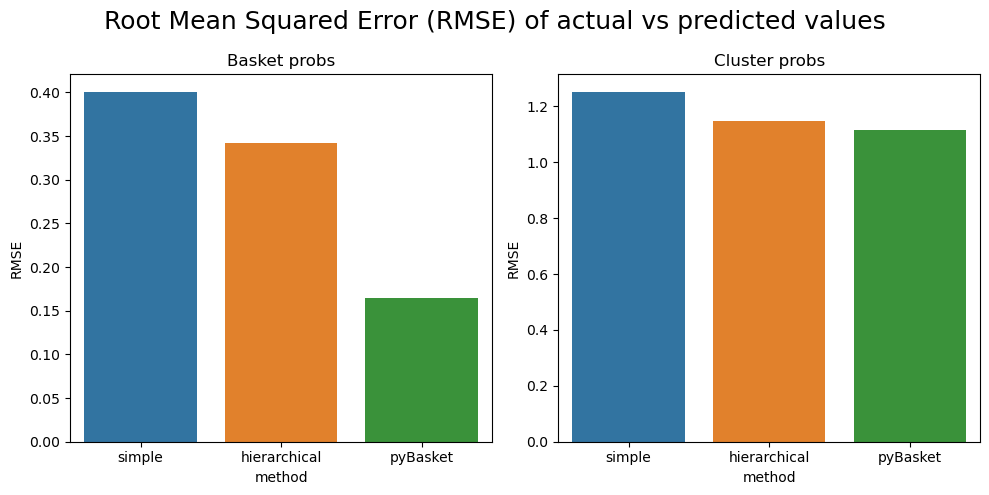

In [51]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(0.5, 1.0, 'Inferred (pyBasket)')

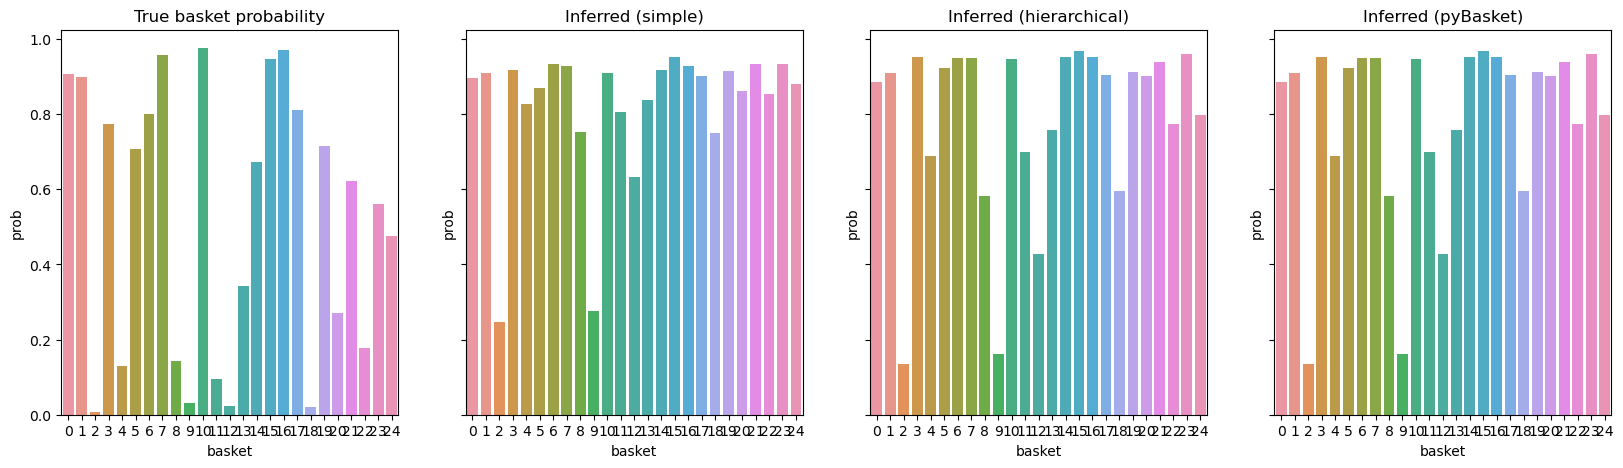

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('True basket probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[3])
ax[3].set_title('Inferred (pyBasket)')

Text(1452.626811594203, 0.5, 'Baskets')

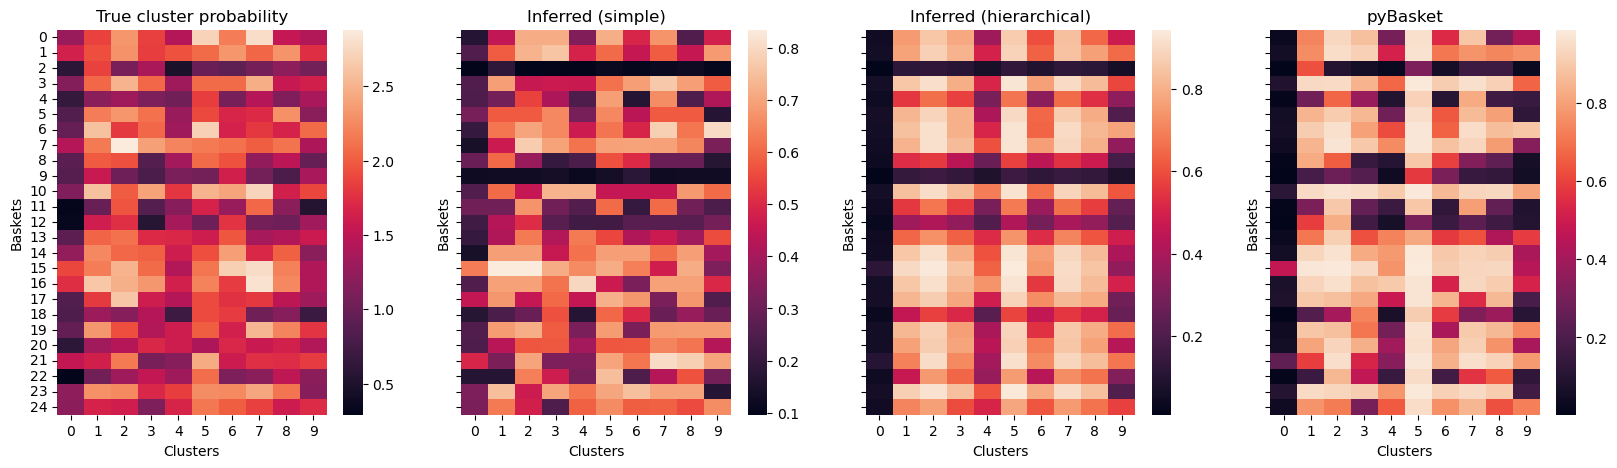

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_joint_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h2, ax=ax[3])
ax[3].set_title('pyBasket')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [55]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [56]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [57]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_joint_p, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_joint_p, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

,method,top,bottom,total,N
0,s,0,1,1,5
1,h1,0,1,1,5
2,h2,0,1,1,5
3,s,1,2,3,10
4,h1,1,5,6,10
5,h2,1,5,6,10
6,s,2,2,4,15
7,h1,3,7,10,15
8,h2,3,7,10,15
9,s,4,5,9,20


Text(0.5, 1.0, 'Correct most-responsive partitions')

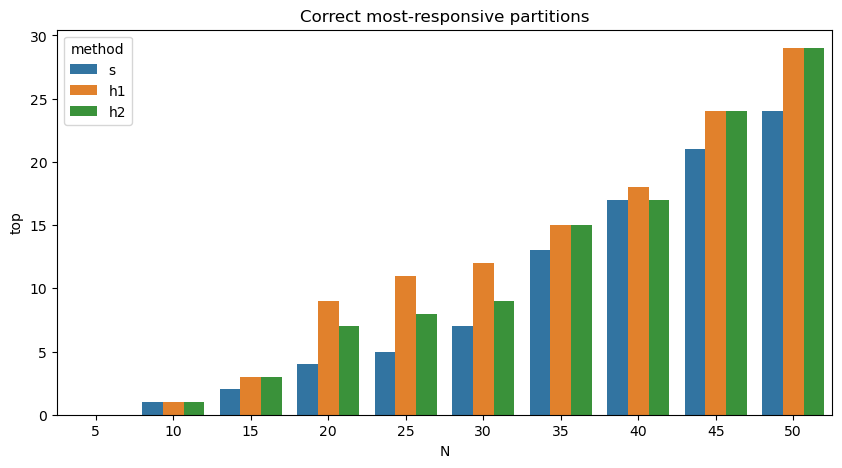

In [58]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

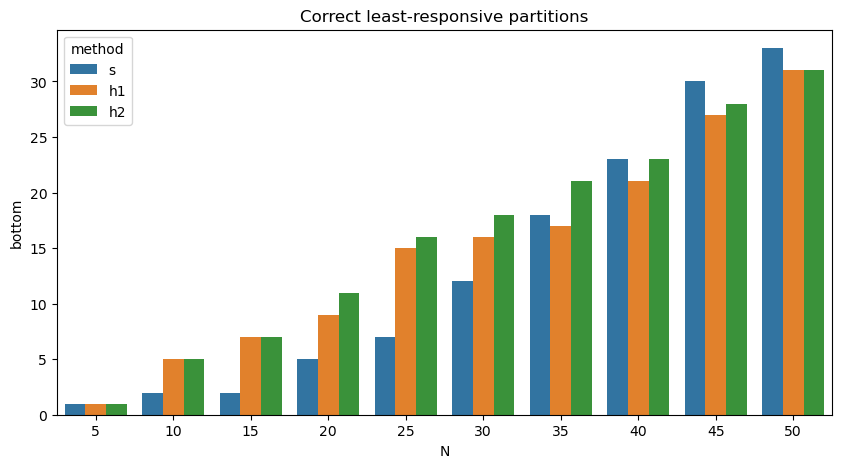

In [59]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [60]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [61]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -254.61     7.24
p_loo       63.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      478   95.6%
 (0.5, 0.7]   (ok)         22    4.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [62]:
loo_h1 = az.loo(trace_h1)
loo_h1

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -220.04    10.81
p_loo       42.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      478   95.6%
 (0.5, 0.7]   (ok)         22    4.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [63]:
loo_h2 = az.loo(trace_pyBasket)
loo_h2

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -189.64    12.90
p_loo       74.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      438   87.6%
 (0.5, 0.7]   (ok)         62   12.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [64]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': loo_s, 
    'hierarchical': loo_h1,
    'pyBasket': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pyBasket,0,-189.640524,74.777086,0.000000,9.999099e-01,12.899746,0.000000,False,log
hierarchical,1,-220.035805,42.704318,30.395281,2.342774e-12,10.806009,6.485625,False,log
simple,2,-254.606966,63.225169,64.966442,9.014734e-05,7.237434,9.290206,False,log


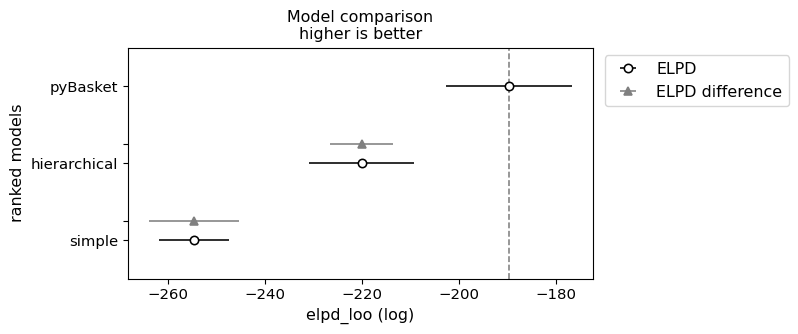

In [65]:
az.plot_compare(df_comp_loo);